# Dataset

As an example I chose the Iris dataset which comprises a set of 150 samples of three different species of Iris (Iris setosa, Iris virginica and Iris versicolor). Each sample comprises four features - sepal length, sepal width, petal length and petal width. 

To create confidence set in 2D we can simply map each sample to 2D space
by discarding remainder of the feature dimensions. Alternativelly we could
use PCA to better reduce the dimensionality.

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

output_folder = 'results'
os.makedirs(output_folder, exist_ok=True)


## Visualization

We can visualize the dataset by plotting each sample in 2D space. This can
be done easily by using the `Seaborn` library


In [3]:
# First load the dataset using pandas dataframe

dataset_path = 'dataset/iris.csv'

df = pd.read_csv(dataset_path)
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [4]:
feature_cols = ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']
classes = ['Setosa', 'Versicolor', 'Virginica']

# We should have even distribution for each class
df['variety'].value_counts()

Setosa        50
Versicolor    50
Virginica     50
Name: variety, dtype: int64

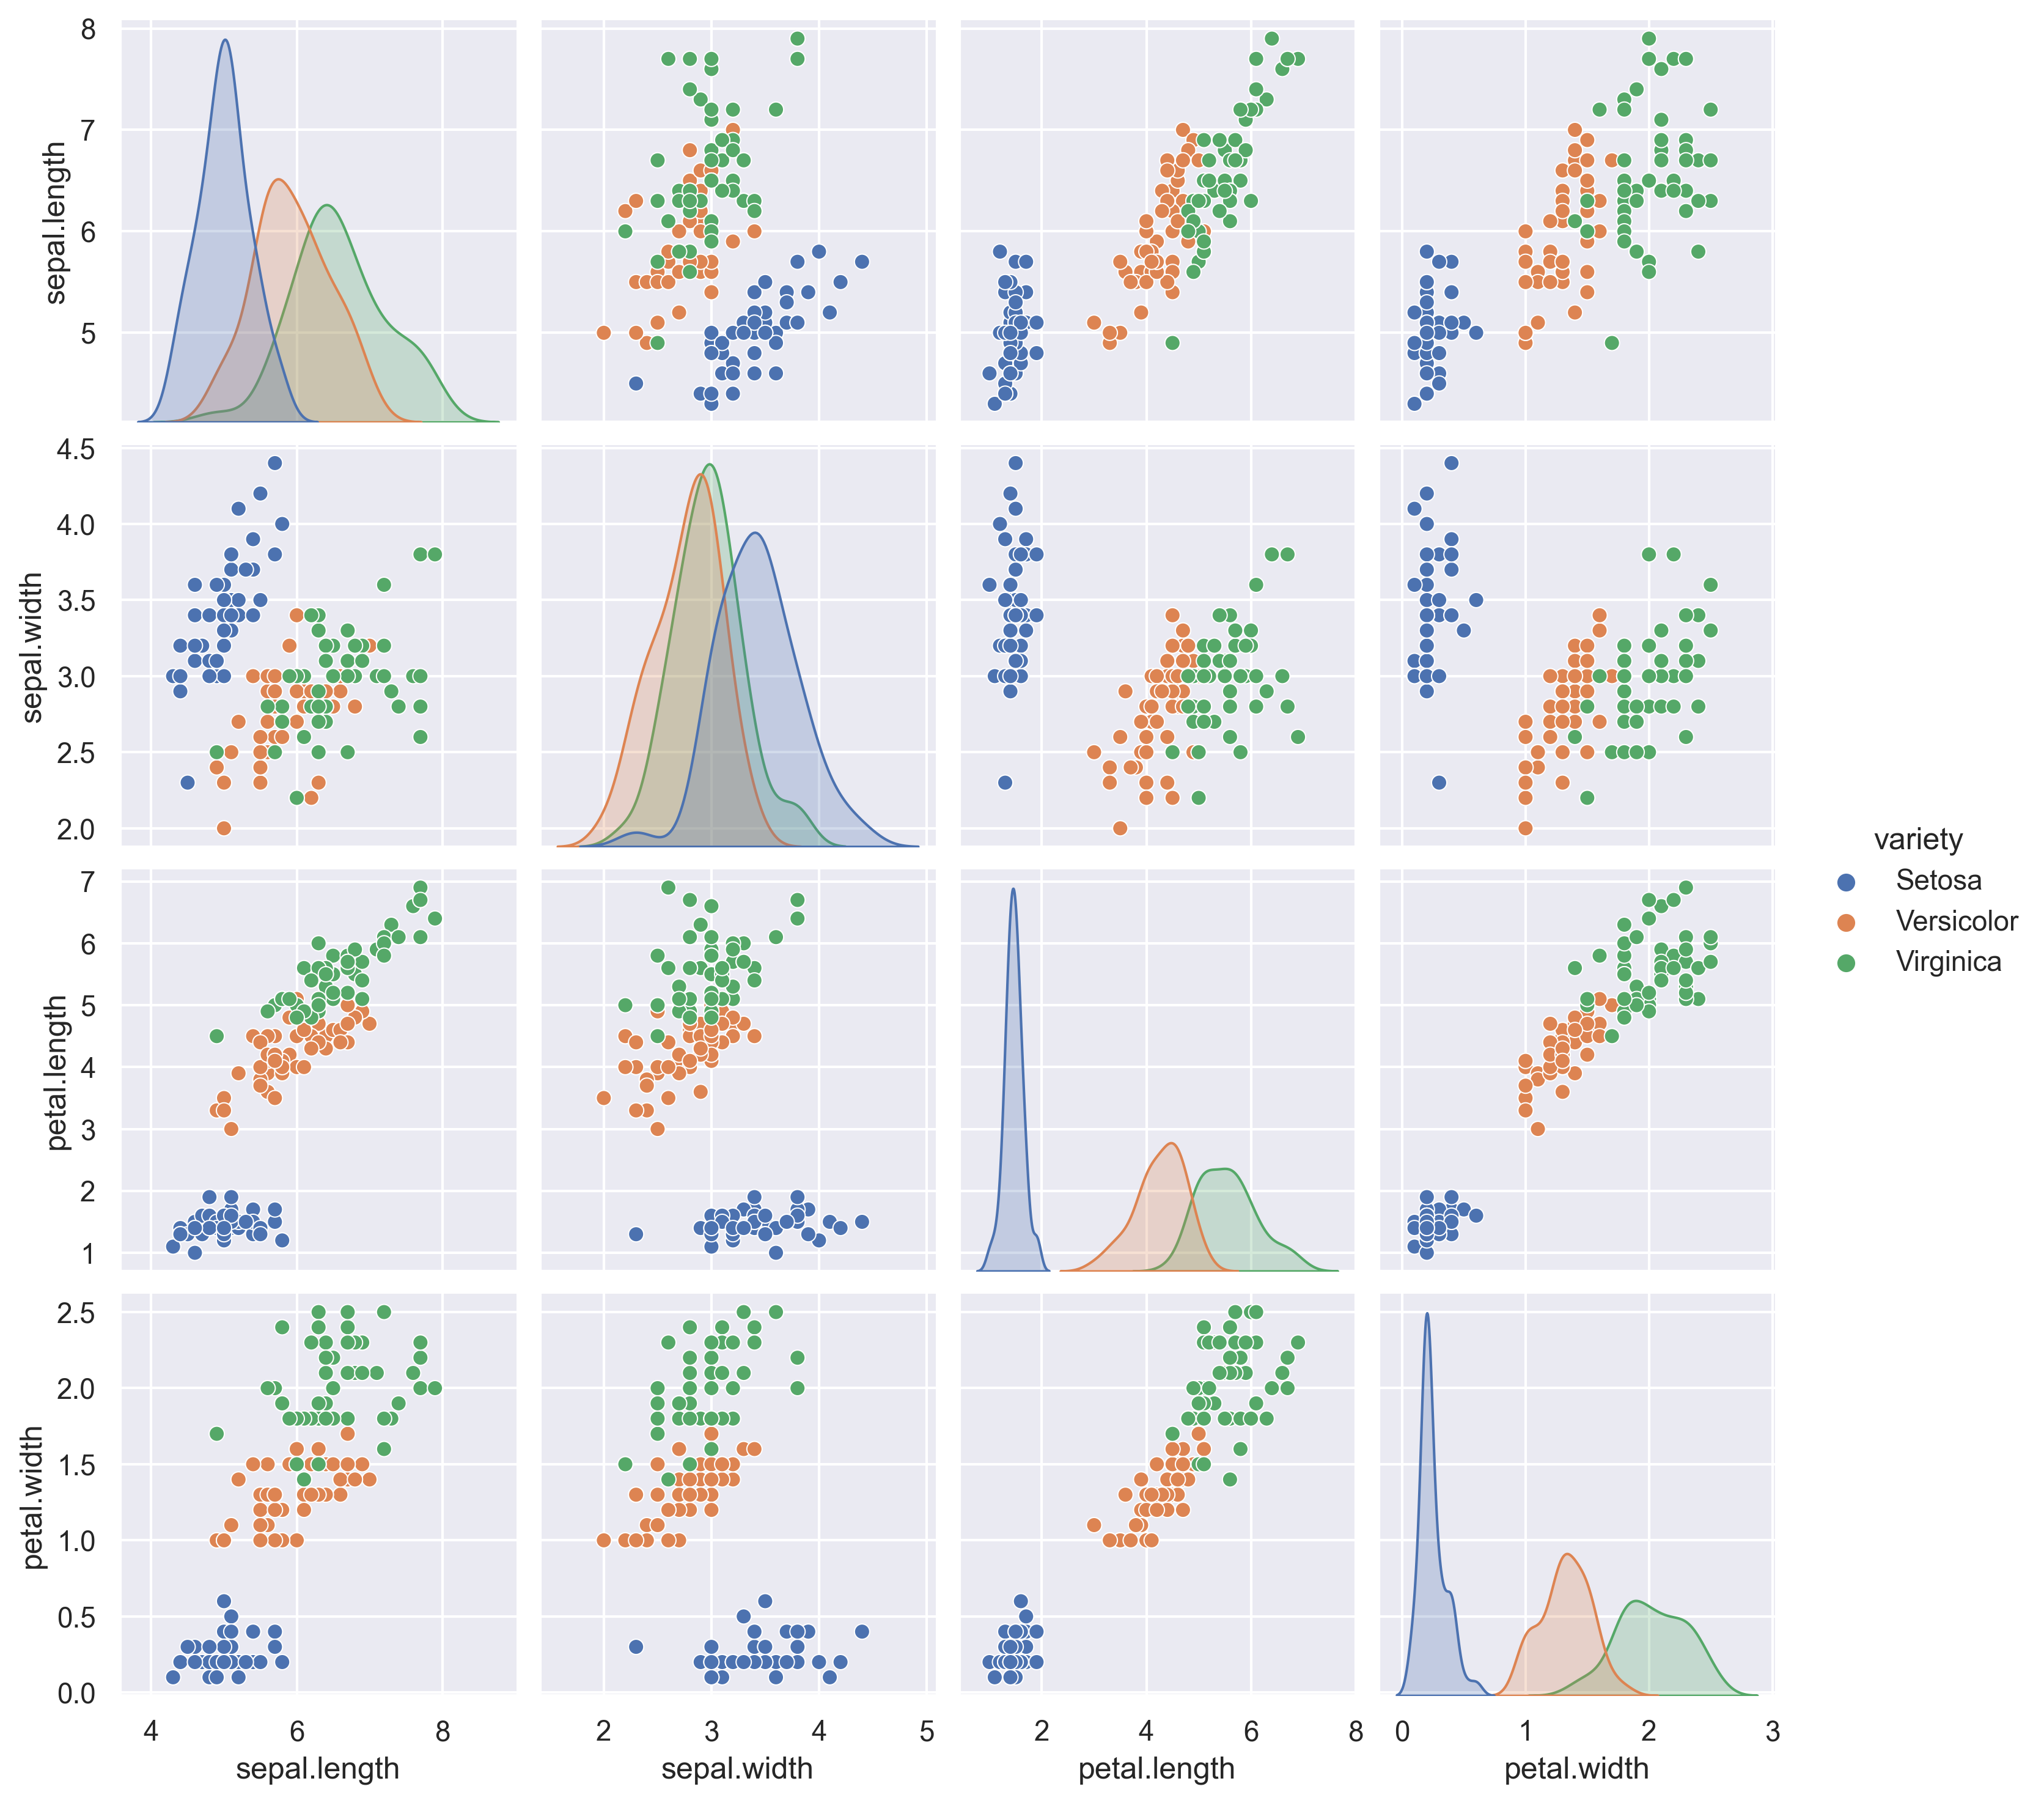

In [14]:
# Pair plot takes seach dimension and plots it against every other dimension
sns.set(rc={'savefig.dpi': 300})
plot = sns.pairplot(df, hue='variety')

fig = plot.fig
fig.savefig(os.path.join(output_folder, 'iris_pairplot.png'))


# Confidence Set / Confidence ellipses construction



In [15]:
from scipy.stats import chi2

def get_confidence_ellipse_params(x, confidence=.95):
    """
    Returns the parameters of the ellipse that represents the confidence region for a 2D Gaussian distribution.

    Args:
        x (np.array): array-like of shape (n_samples, 2)
        confidence (float, optional): The level of confidence, should be between 0 and 1. Defaults to .95.
    """

    # Compute the covariance matrix
    x_mean = np.mean(x, axis=0)
    x_cov = np.cov(x, rowvar=False)

    # Compute the eigenvalues and eigenvectors
    eig_vals, eig_vecs = np.linalg.eig(x_cov)

    # Compute the angle of the ellipse
    angle = np.arctan2(eig_vecs[1, 0], eig_vecs[0, 0])

    # Compute the width and height of the ellipse
    width, height = 2 * np.sqrt(chi2.ppf(confidence, df=2)) * np.sqrt(eig_vals)

    return x_mean, width, height, angle
    

In [16]:
feature_dims = ['sepal.length', 'sepal.width']
x = df[feature_dims].to_numpy()
x.shape

(150, 2)

In [17]:
from matplotlib import patches

x_mean, width, height, angle = get_confidence_ellipse_params(x, confidence=.95)

f'Center: {x_mean}, Width: {width}, Height: {height}, Angle: {angle}'

'Center: [5.84333333 3.05733333], Width: 4.0644383324926885, Height: 2.1134318812635153, Angle: -0.08477983057056589'

In [36]:
import matplotlib.pyplot as plt
import math

def plot_confidence_ellipse(x, confidence, fig, ellipse_color, points_in_color, points_out_color, class_label=None):
    x_mean, width, height, angle = get_confidence_ellipse_params(x, confidence=confidence)
    
    ax = fig.gca()
    
    cos_angle, sin_angle = np.cos(np.pi - angle), np.sin(np.pi - angle)
    x_center = x - x_mean
    x_center = np.stack([x_center[:, 0] * cos_angle - x_center[:, 1] * sin_angle,
                     x_center[:, 0] * sin_angle + x_center[:, 1] * cos_angle], axis=1)

    radius = (x_center[:, 0] ** 2 / (.5 * width) ** 2) + (x_center[:, 1] ** 2 / (.5 * height) ** 2)
    
    points_in, points_out = x[np.where(radius <= 1)], x[np.where(radius > 1)]

    ax.add_patch(patches.Ellipse(x_mean, width, height, angle=math.degrees(angle), 
                                 fill=True, color=ellipse_color))
    ax.scatter(points_in[:, 0], points_in[:, 1], color=points_in_color, label=class_label)
    ax.scatter(points_out[:, 0], points_out[:, 1], color=points_out_color, marker='x', label=f'{class_label} (outlier)' if class_label else None)
    ax.plot(x_mean[0], x_mean[1], 'kx', markersize=3)
    
    

### Plotting for the entire dataset

Here we use the entire dataset - i.e. we ignore the classes

In [57]:
from matplotlib import colors

def plot_dataset(dims, color_in='cornflowerblue', color_out='lightcoral', confidence=.95, save=True):
    """
    Plots the dataset with the confidence ellipse. Ignores class labels.

    Args:
        dims (array): array-like must have exactly 2 elements that are the names of the columns to plot
        color_in (str, optional): Color of the ellipse and inliers. Defaults to 'cornflowerblue'.
        color_out (str, optional): Color of the outliers. Defaults to 'lightcoral'.
        confidence (float, optional): Confidence, must be in (0, 1). Defaults to .95.
        save (bool, optional): Whether to save the figure. Defaults to True.

    Returns:
        fig: figure
    """
    # Create new figure
    fig = plt.figure(dpi=140)
    ellipse_color = colors.to_rgba(color_in, alpha=.4)

    plt.xlabel(dims[0])
    plt.ylabel(dims[1])
    x = df[dims].to_numpy()
    plot_confidence_ellipse(x, confidence=confidence, fig=fig, ellipse_color=ellipse_color,
                            points_in_color=color_in, points_out_color=color_out, class_label='all')

    if save:
        fig.savefig(os.path.join(output_folder, f'iris_{dims[0]}_{dims[1]}_ellipse.png'))
    
    return fig


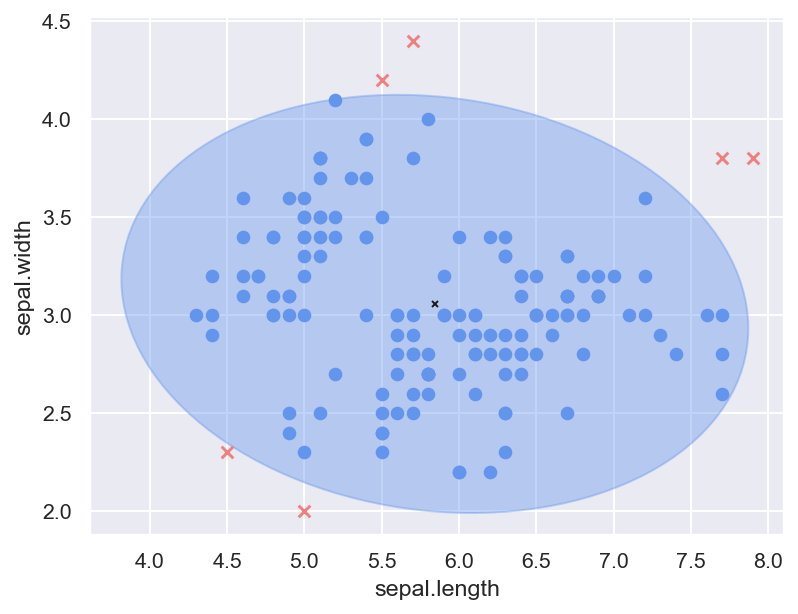

In [58]:
fig = plot_dataset(['sepal.length', 'sepal.width'])

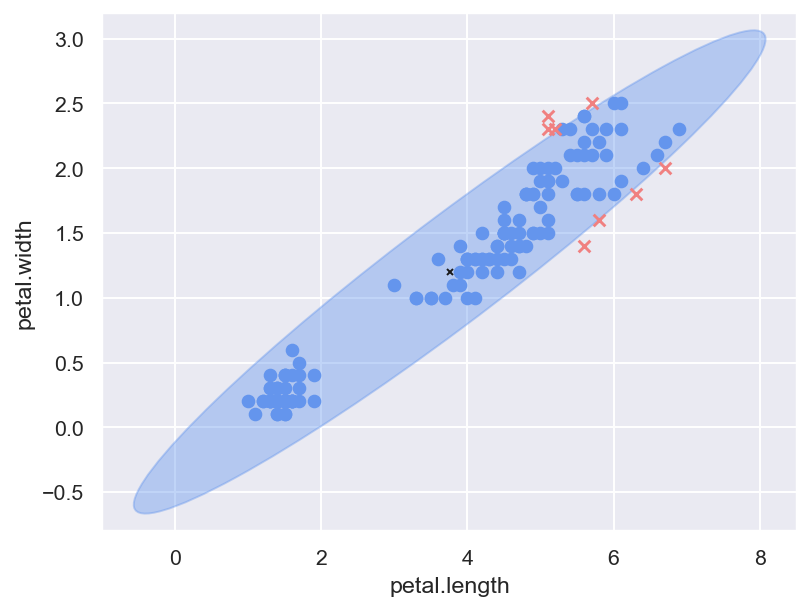

In [59]:
fig = plot_dataset(['petal.length', 'petal.width'])

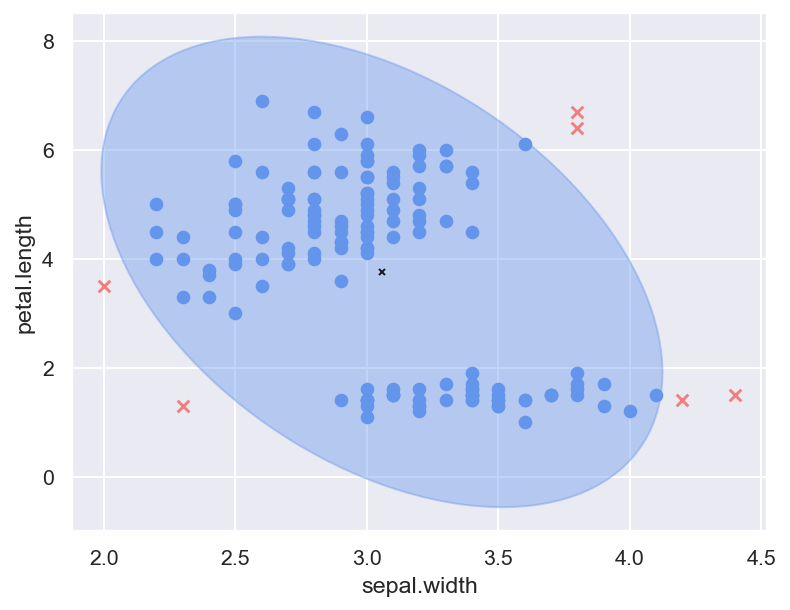

In [60]:
fig = plot_dataset(['sepal.width', 'petal.length'])

### Plotting per class

Alternatively we might want to discard outliers for each class separately.
This visualizes the confidence set for each class as a separate dataset.

In [61]:
def plot_per_class(dims, colors_in, colors_out, confidence=.95, save=True):
    """
    Plots the dataset with the confidence ellipse for each class in the same figure. Each class is plotted with a different color.
    Args:
        dims (array): Dimensions to plot
        colors_in (array): list of colors for the inliers and ellipse for each class
        colors_out (array): list of colors for the outliers for each class
        confidence (float, optional): Confidence. Defaults to .95.
        save (bool, optional): Whether to save the figure to the output file. Defaults to True.
    """
    # Create new figure
    fig = plt.figure(dpi=140)
    ellipse_colors = [colors.to_rgba(color_in, alpha=.2) for color_in in colors_in]

    plt.xlabel(dims[0])
    plt.ylabel(dims[1])
    for i, (class_name, color_in, color_out) in enumerate(zip(classes, colors_in, colors_out)):
        x = df[df['variety'] == class_name][dims].to_numpy()
        plot_confidence_ellipse(x, confidence=confidence, fig=fig, ellipse_color=ellipse_colors[i],
                                points_in_color=color_in, points_out_color=color_out, class_label=class_name)
    plt.legend()

    if save:
        fig.savefig(os.path.join(output_folder, f'iris_{dims[0]}_{dims[1]}_per_class.png'))


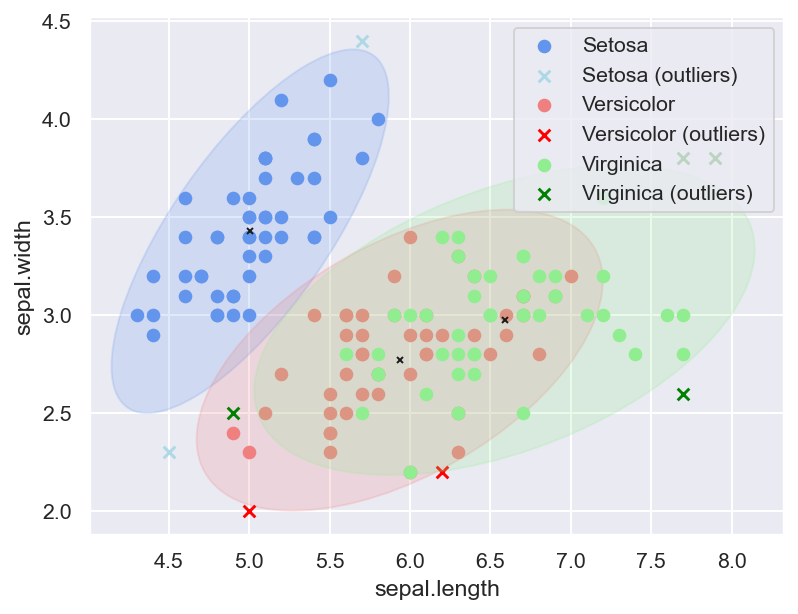

In [62]:
plot_per_class(feature_dims, ['cornflowerblue', 'lightcoral', 'lightgreen'], ['lightblue', 'red', 'green'])